<a href="https://colab.research.google.com/github/techwithanirudh/Shared/blob/master/Toonify_yourself_Flask0Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Toonify yourself!

Please ensure that you're using a GPU runtime

First some setup:

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%tensorflow_version 1.x
!git clone https://github.com/justinpinkney/stylegan2
%cd stylegan2
!nvcc test_nvcc.cu -o test_nvcc -run
!mkdir raw
!mkdir aligned
!mkdir generated

TensorFlow 1.x selected.
Cloning into 'stylegan2'...
remote: Enumerating objects: 269, done.
remote: Total 269 (delta 0), reused 0 (delta 0), pack-reused 269
Receiving objects: 100% (269/269), 2.32 MiB | 30.07 MiB/s, done.
Resolving deltas: 100% (140/140), done.
/content/stylegan2
CPU says hello.
GPU says hello.


## Upload your own photos

Upload your photos to `raw/`. These don't need to be aligned as we'll use a face detector to grab all the faces and transform them into the correct format. One note of caution is that you'll need a pretty high-resolution picture of a face to get a sharp result (the final face crop is resized to 1024x1024 pixels)

We'll grab a example image from the internet to work with.

The basic process is:
- Extract faces and align the images
- Project the images (i.e. find the latent code)
- Toonify the images (i.e. use the latent code with the toon model)

Results will be placed in the stylegan2/generated folder

In [11]:
# !wget https://upload.wikimedia.org/wikipedia/commons/6/6d/Shinz%C5%8D_Abe_Official.jpg -O raw/example.jpg
# from google.colab import files
# import os

# os.chdir('/content/stylegan2/raw')

# uploaded = files.upload()
# for filename in uploaded.keys():
#   print('User uploaded file "{name}" with {length} bytes'.format(name=filename, length=len(uploaded[filename])))

# os.chdir('/content/stylegan2')
path_to_file = '/MyDrive/face.png'
try:
  filename = path_to_file.split('/')
except:
  filename = path_to_file.split('\\')

filename = filename[len(filename) - 1]

with open(f'/content/drive/{path_to_file}', 'rb') as fileData:
  open(f'/content/stylegan2/raw/{filename}', 'a')
  with open(f'/content/stylegan2/raw/{filename}', 'wb') as fileWrite:
    fileWrite.write(fileData.read())

In [ ]:
import os 
os.chdir('/content/stylegan2')

import pretrained_networks

# use my copy of the blended model to save Doron's download bandwidth
# get the original here https://mega.nz/folder/OtllzJwa#C947mCCdEfMCRTWnDcs4qw
blended_url = "https://drive.google.com/uc?id=1H73TfV5gQ9ot7slSed_l-lim9X7pMRiU" 
ffhq_url = "http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-ffhq-config-f.pkl"

_, _, Gs_blended = pretrained_networks.load_networks(blended_url)
_, _, Gs = pretrained_networks.load_networks(ffhq_url)

In [ ]:
!python align_images.py raw aligned

In [ ]:
!python project_images.py --num-steps 500 aligned generated

Loading networks from "http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-ffhq-config-f.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.
Loading images from ".stylegan2-tmp/dataset/images"
detected 1 images ...
Creating dataset ".stylegan2-tmp/dataset/tfrecords"
Adding the images to tfrecords ...
added images 0
Added 1 images.
Projecting image "3a_01.png"...


In [ ]:
import numpy as np
from PIL import Image
import dnnlib
import dnnlib.tflib as tflib
from pathlib import Path

latent_dir = Path("generated")
latents = latent_dir.glob("*.npy")
for latent_file in latents:
  latent = np.load(latent_file)
  latent = np.expand_dims(latent,axis=0)
  synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=False), minibatch_size=8)
  images = Gs_blended.components.synthesis.run(latent, randomize_noise=False, **synthesis_kwargs)
  Image.fromarray(images.transpose((0,2,3,1))[0], 'RGB').save(latent_file.parent / (f"{latent_file.stem}-toon.jpg"))


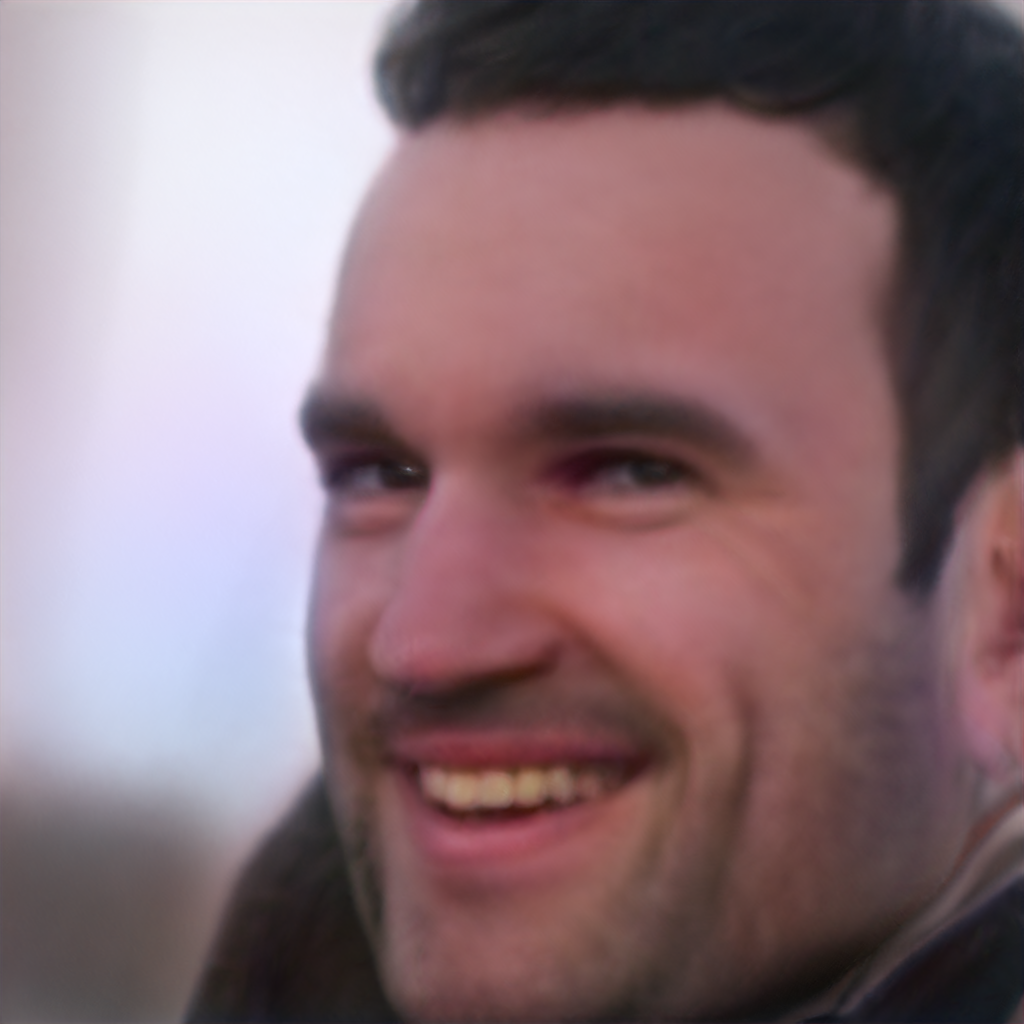

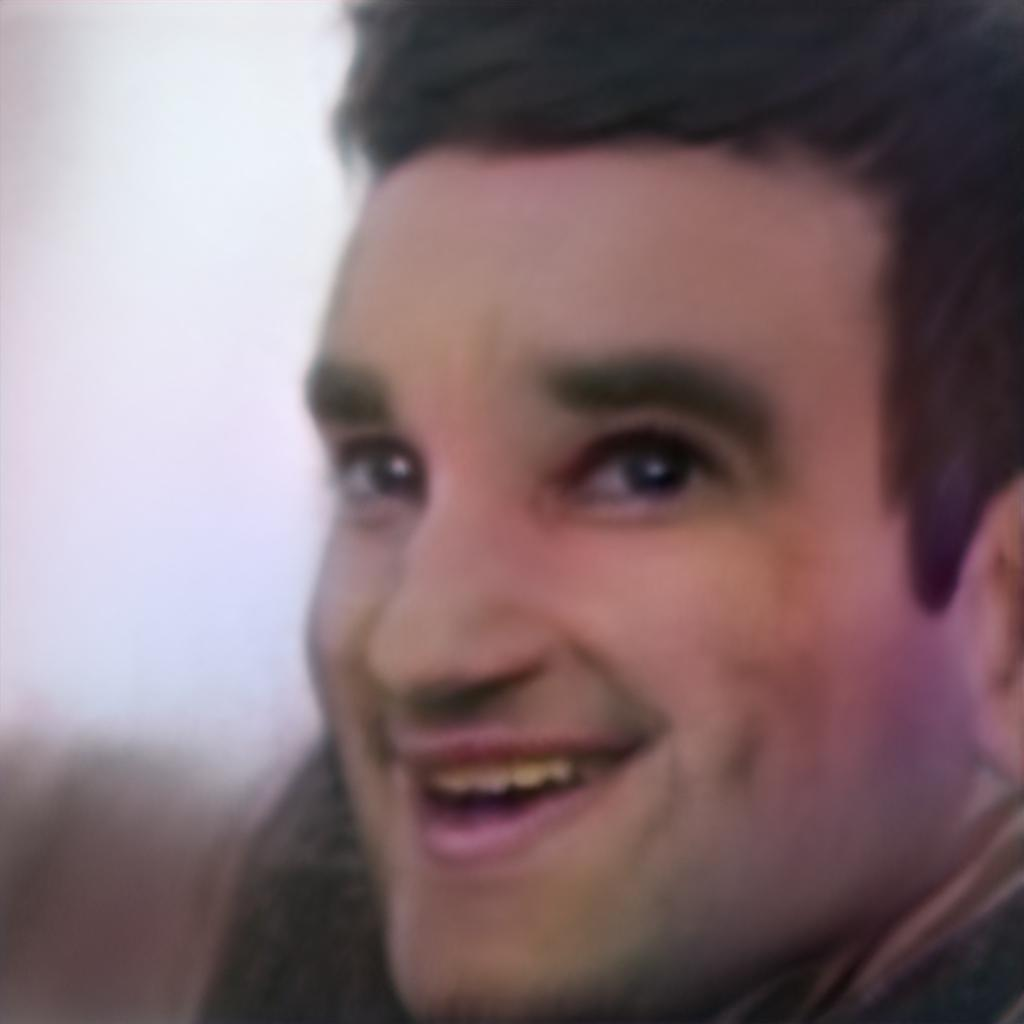

In [ ]:
from IPython.display import Image 
embedded = Image(filename="generated/3a_01.png", width=256)
display(embedded)
tooned = Image(filename="generated/3a_01-toon.jpg", width=256)
display(tooned)